In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
def extract_actor(row):
    all = str(row["Actor and line"]).split(":")
    actor = all[:1]
    line = ": ".join(all[1:])
    # print(actor, line)
    return actor[0], line

def split_episode_and_series(row):
    all = str(row["Episode_det"]).split(" ")
    serie = " ".join(all[:3])
    episode = " ".join(all[3:])
    return episode, serie

text = pd.read_csv("data/all_scripts.txt", header=None, delimiter=">")
text = text.rename(columns={0: "Actor and line", 1: "Scene", 2: "Episode_det"})
text[["Scene", "Episode_det"]] = text[["Scene", "Episode_det"]].ffill(axis=0)
text[["Episode", "Serie"]] = text.apply(lambda row: split_episode_and_series(row), axis=1, result_type="expand")
text = text.dropna(axis=0, subset=['Actor and line'])
text[["Actor", "Line"]] = text.apply(lambda row: extract_actor(row), axis=1, result_type="expand")
text = text.drop(["Actor and line", "Episode_det"], axis=1)
text[3000:]

,Scene,Episode,Serie,Actor,Line
3129,The cafeteria.,Episode 13 – The Bat Jar Conjecture,Series 01,Sheldon,He does.
3130,The cafeteria.,Episode 13 – The Bat Jar Conjecture,Series 01,Leonard,"I move we are the Army Ants, all those in fav..."
3132,The apartment.,Episode 13 – The Bat Jar Conjecture,Series 01,Penny,"Good afternoon, and welcome to today’s physic..."
3133,The apartment.,Episode 13 – The Bat Jar Conjecture,Series 01,Leonard,Yes.
3134,The apartment.,Episode 13 – The Bat Jar Conjecture,Series 01,Sheldon,Of course.
...,...,...,...,...,...
54323,Sheldon’s office.,Episode 24 – The Long Distance Dissonance,Series 10,Ramona,"Mmm. No big deal, I enjoy spending time with ..."
54324,Sheldon’s office.,Episode 24 – The Long Distance Dissonance,Series 10,Sheldon,"And I with you. Question, are you seeking a r..."
54325,Sheldon’s office.,Episode 24 – The Long Distance Dissonance,Series 10,Ramona,What if I were?
54326,Sheldon’s office.,Episode 24 – The Long Distance Dissonance,Series 10,Sheldon,"Well, that would raise a number of problems. ..."


In [3]:
print(text[["Scene", "Serie"]].groupby("Serie").count())

            Scene
Serie            
 Series 01   4136
 Series 02   5238
 Series 03   5030
 Series 04   5604
 Series 05   4847
 Series 06   4885
 Series 07   5345
 Series 08   5269
 Series 09   5418
 Series 10   5520


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [4]:
all_char = set(text['Actor'])
print(all_char)
char_mask = text[['Actor', 'Line']].groupby('Actor').count() >= 90
rec_char = set(char_mask[char_mask.values == True].index)
print(rec_char)
rec_char.discard('Man')
print(rec_char)

{'Gablehauser', 'Everyone', 'Mark Harmon on TV', 'Angela', 'Together', 'Phone rings. Answering machine', 'Mass', 'Siri', 'Howard’s phone', 'Mike M', 'Waiter', 'Awkward guy', 'Stephen Hawking', 'Page', 'Mr. Rostenkowski', 'Mrs Latham', 'Barry', 'Zack', 'Woman on TV', 'Doctor', 'Theatre staff', 'Greene', 'Dale', 'Penny-warrior', 'Helium Man', 'Red-haired guy', 'Katee Sackhoff', 'Sheldon', 'Psychic', 'Clerk', 'Tattooist', 'Wil', 'Third Floor Janitor', 'Cleaner', 'Col. Williams', 'Ramona', 'Receptionist', 'Wil Wheaton', 'Ira', 'Isabella', 'Brent', 'Mrs Fowler', 'Mr Rostenkowski', 'Dr Gallo', 'Man on TV', 'Girls', 'Lakshmi', 'Siebert', 'Man', 'Marty', 'Security Guard', 'Policeman', 'Second child', 'Stephen', 'Mike', 'Alice', 'First Girl', 'Dave', 'Girl', 'Seibert', 'Jimmy', 'Dr Lorvis', 'Computer voice', 'Sheldon-bot', 'Dan', 'Cosmonaut', 'Bert', 'Voice', 'Actress', 'Answerphone', 'Barman', 'Cole', 'LeVar', 'Bill', 'Sarah', 'Vet', 'Mrs Koothrappali', 'Barber', 'Jesse', 'Steve Wozniak', 'War

In [5]:
print(f"Lines before : {len(text)}")
text = text[text['Actor'].isin(rec_char)]
print(f"Lines after : {len(text)}")

Lines before : 51292
Lines after : 48346


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [6]:
print(list(EXCLUDE_CHARS))
text['Line'] = text['Line'].replace(list(EXCLUDE_CHARS), ' ')
text['Line'] = text.apply(lambda row: row['Line'].lower(), axis=1)
text[:5]

[']', '\\', '!', '%', '[', '-', '^', ':', ',', '@', '>', '.', '`', ';', '{', '~', '&', "'", '+', '|', '}', '?', '/', '$', '#', '’', '"', ')', '*', '<', '=', '(', '_']


,Scene,Episode,Serie,Actor,Line
2,A corridor at a sperm bank.,Episode 01 – Pilot Episode,Series 01,Sheldon,so if a photon is directed through a plane wi...
3,A corridor at a sperm bank.,Episode 01 – Pilot Episode,Series 01,Leonard,"agreed, what’s your point?"
4,A corridor at a sperm bank.,Episode 01 – Pilot Episode,Series 01,Sheldon,"there’s no point, i just think it’s a good id..."
5,A corridor at a sperm bank.,Episode 01 – Pilot Episode,Series 01,Leonard,excuse me?
7,A corridor at a sperm bank.,Episode 01 – Pilot Episode,Series 01,Leonard,"one across is aegean, eight down is nabakov, ..."


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

Counter({'i': 17447, 'you': 16580, 'the': 15029, 'to': 14010, 'a': 13373, 'and': 8603, 'of': 7262, 'in': 5288, 'that': 5147, 'is': 4962, 'my': 4773, 'i’m': 4689, 'it': 4679, 'have': 3838, 'with': 3830, 'we': 3705, 'for': 3635, 'your': 3594, 'what': 3549, 'it’s': 3526, 'oh,': 3410, 'not': 3376, 'this': 3344, 'don’t': 3253, 'on': 3169, 'just': 3141, 'be': 3065, 'was': 3063, 'do': 2883, 'are': 2820, 'but': 2799, 'me': 2731, 'you’re': 2642, 'well,': 2599, 'if': 2471, 'like': 2410, 'all': 2250, 'so': 2206, 'about': 2156, 'get': 2068, 'can': 2040, 'he': 2010, 'that’s': 2008, 'at': 1963, 'know': 1833, 'how': 1833, 'no,': 1764, 'it.': 1745, 'you.': 1645, 'yeah,': 1606, 'want': 1568, 'out': 1541, 'an': 1522, 'think': 1492, 'okay,': 1476, 'going': 1451, 'when': 1394, 'she': 1340, 'one': 1324, 'why': 1310, 'up': 1307, 'as': 1305, 'go': 1304, 'got': 1299, 'would': 1271, 'did': 1241, 'her': 1203, 'me.': 1154, 'come': 1129, 'uh,': 1125, 'know,': 1107, 'his': 1100, 'they': 1087, 'no': 1072, 'gonna': 

<BarContainer object of 38576 artists>

c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  func(*args, **kwargs)
c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from current font.
  func(*args, **kwargs)
c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  func(*args, **kwargs)
c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  func(*args, **kwargs)
c:\Users\helli\anaconda3\envs\ada\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 

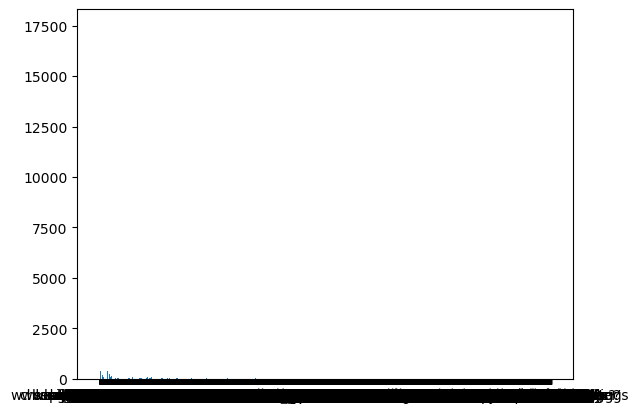

In [12]:
from collections import Counter
full_text = ' '.join(text['Line'])
tokens = simple_tokeniser(full_text)
tokens_count = Counter(tokens)
print(tokens_count)
print(tokens_count.keys())
print(tokens_count.values())
# plt.bar(tokens_count.keys(), tokens_count.values())
# it's the zipf's law : stop words are so much more frequent than others

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [15]:
talkative = {}
for char in rec_char:
    char_text = text[text['Actor'] == char]
    full_text_char = ' '.join(char_text['Line'])
    char_tokens = simple_tokeniser(full_text_char)
    talkative[char] = len(char_tokens)
    print(f"{char} is speaking {len(char_tokens)} words")

sorted_talkative = sorted(talkative.items(), key=lambda x:x[1])
print(sorted_talkative)

Mrs Wolowitz is speaking 1364 words
Emily is speaking 1472 words
Mrs Cooper is speaking 3205 words
Leslie is speaking 1164 words
Howard is speaking 64994 words
Penny is speaking 74252 words
Priya is speaking 1824 words
Amy is speaking 37384 words
Zack is speaking 1336 words
Beverley is speaking 1918 words
Bert is speaking 1065 words
Arthur is speaking 1353 words
Kripke is speaking 1163 words
Sheldon is speaking 174920 words
Wil is speaking 1577 words
Raj is speaking 56391 words
Stuart is speaking 7407 words
Bernadette is speaking 25808 words
Leonard is speaking 95620 words
[('Bert', 1065), ('Kripke', 1163), ('Leslie', 1164), ('Zack', 1336), ('Arthur', 1353), ('Mrs Wolowitz', 1364), ('Emily', 1472), ('Wil', 1577), ('Priya', 1824), ('Beverley', 1918), ('Mrs Cooper', 3205), ('Stuart', 7407), ('Bernadette', 25808), ('Amy', 37384), ('Raj', 56391), ('Howard', 64994), ('Penny', 74252), ('Leonard', 95620), ('Sheldon', 174920)]


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [8]:
# your code goes here

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [9]:
# your code goes here